# The Battle Of Neighborhoods In The City Of Surabaya

## Applied Data Science Capstone Project By IBM Offered Through Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, I take a role as an analyst that <b>help hotel managers or owners</b> in <b>deciding which part of Surabaya is the best location to establish a new luxury (5 stars) hotel</b>. Location is the most crucial aspect for hotel owners, because different locations may have different surroundings and venues that also attract different types of travelers. The success of a hotel depends largely on the location of its site. For this reason, hotel owners must carefully decide which parts of the city to choose according to the type and price of the hotel. In order to decide the most appropriate location, there are several factors that should be considered in advanced. <b>For this project, the factor to be considered is the surrounding location offering, such as restaurants, bus line, banks, and so forth.</b> In addition, this project will focus only on the <b>city of Surabaya</b>, as the second largest city in Indonesia and the capital of the province of East Java.

## Data <a name="data"></a>

The data required to solve the problem of deciding the best location to establish a new hotel in Surabaya area are:

<ol>
    <li><b>Basic neighborhoods information</b><br>
        Data Source: <a href="https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Kota_Surabaya">Wikipedia page</a><br>
Description: The Wikipedia page contains the neighborhood basic information, such as unique code and name in the form of HTML which will be scrapped to get the data
    </li>
    <br>
    <li><b>Coordinates of neighborhoods (latitude, longitude)</b> <br>
        Data Source: The neighborhoods data are provided in a CSV file named "indonesian_coordinates.csv" located on the same folder as this notebook <br>
Description: The CSV file contains a dataset of each Indonesia neighborhoods coordinate information. So, to obtain data only for the city of Surabaya, a portion of the dataset will be selected
</li>
    <br>
    <li><b>Venues information in each neighborhood</b> <br>
Data Source: Foursquare <br>
Description: By using the Foursquare API, a list of venues can be obtained along with information, such as categories and coordinates</li>
</ol>

### Import Necessary Packages

In [44]:
# For data analysis
import pandas as pd
import numpy as np

# For scrapping
import requests
from bs4 import BeautifulSoup

# For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline 

# For mapping
import folium
from IPython.display import Image
from IPython.core.display import HTML 

from IPython.display import display

# kMeans Machine Learning
from sklearn.cluster import KMeans 

### Obtain Basic Neighborhoods Information

In [2]:
# Target url
url = 'https://id.wikipedia.org/wiki/Daftar_kecamatan_dan_kelurahan_di_Kota_Surabaya'

# Wikipedia Page in raw HTML format
page = requests.get(url)

# Scrape the data using BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

# Find the table
table = soup.find('table')

# Scrape title
table_titles = table.find_all('th')

df_title_row = []
for title in table_titles:
    # Stop the loop when the df_title_row has already 4 elements
    if len(df_title_row) == 4: break
    
    df_title_row.append(title.text.rstrip())

# Scrape body
table_rows = table.find_all('tr')

df_row = []
for tr in table_rows:
    tds = tr.find_all('td')
    
    row = []
    for td in tds:
        row.append(td.text.rstrip())
    df_row.append(row)

df_neigh_basic = pd.DataFrame(df_row, columns=df_title_row)
df_neigh_basic.head()

,Kode Kemendagri,Kecamatan,Jumlah Kelurahan,Daftar Kelurahan
0,None,None,None,None
1,35.78.28,Asemrowo,3,\nAsemrowo\nGenting Kalianak\nTambak Sarioso
2,35.78.19,Benowo,4,\nKandangan\nRomokalisari\nSememi\nTambak Osow...
3,35.78.13,Bubutan,5,\nAlun-Alun Contong\nBubutan\nGundih\nJepara\n...
4,35.78.29,Bulak,4,\nBulak\nKedungcowek\nKenjeran\nSukolilo Baru


The above dataset looks similar to the table on the Wikipedia page. Subsequently, the columns are unique code, neighborhood's name, number of sub district, and list of sub districts. But, I am interested only on the neighborhood's code and name. So only the first and second columns will be picked and the columns will be renamed to 'code' and 'neighborhood_name'

In [3]:
df_neigh_basic_cleaned = df_neigh_basic.iloc[:,0:2]
df_neigh_basic_cleaned.columns = ['code', 'neighborhood_name']
df_neigh_basic_cleaned.head()

,code,neighborhood_name
0,None,None
1,35.78.28,Asemrowo
2,35.78.19,Benowo
3,35.78.13,Bubutan
4,35.78.29,Bulak


The code column in the df_neigh_basic_cleaned is formated as follows: [province code].[city code].[neighborhood.code]. I will obtain only the neighborhood code which is located at the third (last) position since I am interested only on that feature.

In [4]:
df_neigh_basic_cleaned.insert(1, 'neighborhood_code', '', True)

df_neigh_basic_cleaned = df_neigh_basic_cleaned.loc[1:,]

for index, row in df_neigh_basic_cleaned.iterrows():
    try:
        codes_list = row['code'].split('.')
        row['neighborhood_code'] = codes_list[2]
        
        # Uppercase the neighborhood name
        row['neighborhood_name'] = row['neighborhood_name'].upper()
    except:
        None

# Remove the code column (0-index position) after the district and neighborhood code is added
del df_neigh_basic_cleaned['code']
      
# Preview the data
df_neigh_basic_cleaned.head()

,neighborhood_code,neighborhood_name
1,28,ASEMROWO
2,19,BENOWO
3,13,BUBUTAN
4,29,BULAK
5,21,DUKUH PAKIS


In [5]:
df_neigh_basic_cleaned.shape

(32, 2)

The neighborhood's basic information data frame has 32 rows and 2 columns.

### Obtain neighborhoods' coordinates

In [6]:
# Get coordinates
df_coor = pd.read_csv('indonesian_coordinates.csv')
df_coor.head()

,province_code,kabupaten_code,kecamatan_code,lat,lng,province_name,kabupaten_name,kecamatan_name
0,11,2,42,2.534933,97.937495,NANGGROE ACEH DARUSSALAM,ACEH SINGKIL,SINGKOHOR
1,11,4,10,3.437859,97.817760,NANGGROE ACEH DARUSSALAM,ACEH TENGGARA,LAWE ALAS
2,11,4,20,3.356981,97.926602,NANGGROE ACEH DARUSSALAM,ACEH TENGGARA,LAWE SIGALA-GALA
3,11,4,21,3.316513,97.991986,NANGGROE ACEH DARUSSALAM,ACEH TENGGARA,BABUL MAKMUR
4,11,4,30,3.457155,97.904820,NANGGROE ACEH DARUSSALAM,ACEH TENGGARA,BAMBEL


The data frame above contains the coordinates for all neighborhoods in Indonesia. I will keep only the records for certain neighborhoods particular that located in the city of Surabaya.

In [7]:
# Initially, choose the city name as Surabaya
df_coor = df_coor[df_coor['kabupaten_name'] == 'SURABAYA']

# Select columns
df_coor = df_coor[['kecamatan_name', 'lat', 'lng']]

# Rename column name
df_coor.rename(columns={'kecamatan_name': 'neighborhood_name'}, inplace=True)

df_coor.head()

,neighborhood_name,lat,lng
2440,KARANG PILANG,-7.337777,112.688397
2441,JAMBANGAN,-7.321082,112.718192
2442,GAYUNGAN,-7.330843,112.724151
2443,WONOCOLO,-7.319820,112.742027
2444,TENGGILIS MEJOYO,-7.324226,112.753945


In [8]:
# Join the df_neigh_basic_cleaned & df_coor on neighborhood_name
df_neigh = df_neigh_basic_cleaned.join(df_coor.set_index('neighborhood_name'), on='neighborhood_name')

# Preview the new joinned df
df_neigh.head(10)

,neighborhood_code,neighborhood_name,lat,lng
1,28,ASEMROWO,-7.234688,112.685417
2,19,BENOWO,-7.226488,112.649662
3,13,BUBUTAN,-7.249962,112.730110
4,29,BULAK,-7.236774,112.789697
5,21,DUKUH PAKIS,-7.296838,112.700315
6,22,GAYUNGAN,-7.330843,112.724151
7,07,GENTENG,-7.259088,112.747986
8,08,GUBENG,-7.278906,112.753945
9,25,GUNUNG ANYAR,-7.339163,112.804593
10,23,JAMBANGAN,-7.321082,112.718192


In [9]:
# check the new df's dimension
df_neigh.shape

(32, 4)

The coordinate data frame also contains 32 rows which indicates a match between the data in this data frame and the data in neighborhoods basic information data frame.

### Obtain Venues Information 

In this section, I am going to obtain the closest venues data within 500m radius from each neighborhood.

Foursquare API is used to get the data for nearby venues. Before making a request to the API, several parameters are required, and will be specified in the  cell bellow.

In [46]:
CLIENT_ID = '[CLIENT_ID]' # your Foursquare ID
CLIENT_SECRET = '[CLIENT_SECRET]' # your Foursquare Secret
ACCESS_TOKEN = '[ACCESS_TOKEN]' # your FourSquare Access Token

In [11]:
VERSION = '20180604'
LIMIT = 30
RADIUS = 500

The function below is used as a helper function to query nearest venues for each neighborhood within a certain radius. This function takes several parameters, such as a list of names, latitude, longitude, and radius value to query the nearest venues. The output of this function is a new data frame containing the venues information as well as the original data frame value.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # Request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # Only some information for each nearby venue will be used
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['neighborhood_name', 
                          'neighborhood_lat', 
                          'neighborhood_lng', 
                          'venue', 
                          'venue_lat', 
                          'venue_lng', 
                          'venue_category']
        except:
            print("Venue information cannot be queried at this moment")
    
    return(nearby_venues)

In [13]:
# This process will take a few seconds
df_venues = getNearbyVenues(
    df_neigh['neighborhood_name'], df_neigh['lat'], df_neigh['lng'], RADIUS
)

# Preview the venues dataset
df_venues.head()

Venue information cannot be queried at this moment


,neighborhood_name,neighborhood_lat,neighborhood_lng,venue,venue_lat,venue_lng,venue_category
0,ASEMROWO,-7.234688,112.685417,Es Legen pinggir Jalan,-7.233280,112.684251,Food Truck
1,BENOWO,-7.226488,112.649662,"Benowo Trade Centre [ BTC ], Benowo, Surabaya",-7.225492,112.648972,Shoe Store
2,BUBUTAN,-7.249962,112.730110,Kampoeng Ilmu,-7.251933,112.728690,Bookstore
3,BUBUTAN,-7.249962,112.730110,Dunkin',-7.248629,112.730910,Donut Shop
4,BUBUTAN,-7.249962,112.730110,Pasar Turi,-7.246576,112.732809,Market


## Methodology <a name="methodology"></a>

This project is for audiences interested in discovering which neighborhood in Surabaya is the best for setting up a new 5-star luxury hotel. In this project, I will analyze the density in each neighborhood and predict which has the most venues nearby to setup a new 5-star luxury hotel. 

There are several processes involved in this project.
First, the data needed to answer the problem will be collected through various sources. The data collection process has been caried out in the data section above. After that, I will perform data wrangling to clean up the data so that it can be used for further analysis.

Second, I will perform an Exploratory Data Analysis (EDA) on the cleaned data set to see the main characteristics of the data. The analysis I will do is as follows:
<ul>
    <li>
        Summary statistics in the form of pivot tables to summarize and group neighborhoods and venues data</li>
    <li>Bar graph to compare the number of venues for each neighborhood and boxplot to see how the values in the data are spread out</li>
    <li>Map to locate venue on Surabaya map</li>
</ul>
    
Last but no least, a cluster model that uses k-Means algorithm will be used to cluster each different neighborhood based on the similarity of venues. k-Means is used because it guarantees convergence and generalizes to clusters of different shapes and sizes. I will choose 5 as the k value, which means that the neighborhood will be clustered to 5 different groups.

## Analysis <a name="analysis"></a>

Now that the venue data frame has been loaded, let's have a preview by grouping the neighborhood names and total occurances.

In [14]:
df_venues_grouped = df_venues.groupby('neighborhood_name').count()
df_venues_grouped.head(10)

,neighborhood_lat,neighborhood_lng,venue,venue_lat,venue_lng,venue_category
neighborhood_name,,,,,,
ASEMROWO,1,1,1,1,1,1
BENOWO,1,1,1,1,1,1
BUBUTAN,8,8,8,8,8,8
BULAK,1,1,1,1,1,1
GAYUNGAN,8,8,8,8,8,8
GENTENG,25,25,25,25,25,25
GUBENG,25,25,25,25,25,25
GUNUNG ANYAR,3,3,3,3,3,3
JAMBANGAN,5,5,5,5,5,5


In [15]:
# The total venues for each neighborhood equals to any one of the column name besides the neighborhood_name
# so I will rename the first column to 'total_venues' and drop all the remaining columns
df_venues_grouped.rename(columns={ df_venues_grouped.columns[0]: "total_venues" }, inplace = True)

ix_cols_to_be_removed = [x for x in range(1, len(df_venues_grouped.columns))]
cols_to_be_removed = df_venues_grouped.columns[ix_cols_to_be_removed]
df_venues_grouped.drop(cols_to_be_removed ,axis=1,inplace=True)

# Sort by total_venues in descending order
df_venues_grouped.sort_values(by=['total_venues'], ascending=True, inplace=True)

# Reset the index
df_venues_grouped.reset_index(inplace=True)

# Preview the df's tail
df_venues_grouped.tail()

,neighborhood_name,total_venues
23,TAMBAKSARI,15
24,WONOCOLO,21
25,GUBENG,25
26,GENTENG,25
27,TEGALSARI,27


Let's visualize the data frame above by plotting it onto a horizontal bar graph.

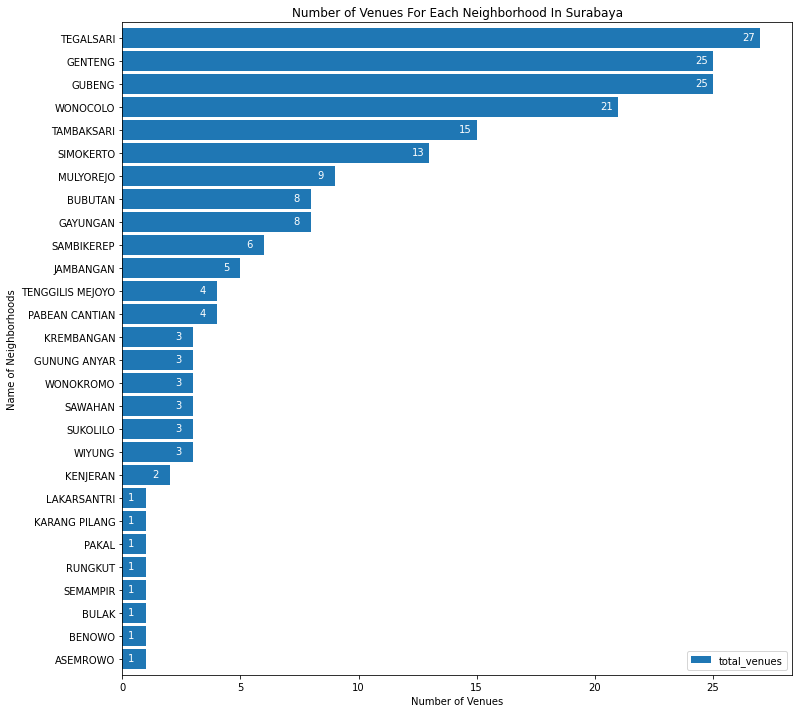

In [16]:
df_venues_grouped.plot(
    kind='barh', 
    figsize=(12, 12), 
    x='neighborhood_name', 
    y='total_venues',
    width=0.85,
) 

plt.xlabel('Number of Venues')
plt.ylabel('Name of Neighborhoods')
plt.title('Number of Venues For Each Neighborhood In Surabaya')

# annotate value labels to each country
for index, row in df_venues_grouped.iterrows(): 
    value = row['total_venues']
    label = int(value) # format int with commas
    
    # place text at the end of bar
    plt.annotate(label, xy=(value-0.75, index-0.10), color='white')

plt.show()

As can be seen, the bar graph shows that there are three neighborhoods that stand out the most in the number of venues, namely TEGALSARI, GENTENG, and GUBENG. On the other hand, there are 8 neighborhoods with only one venue.

Now, let's plot a box plot to see the distribution of total venues accross all neighborhoods.

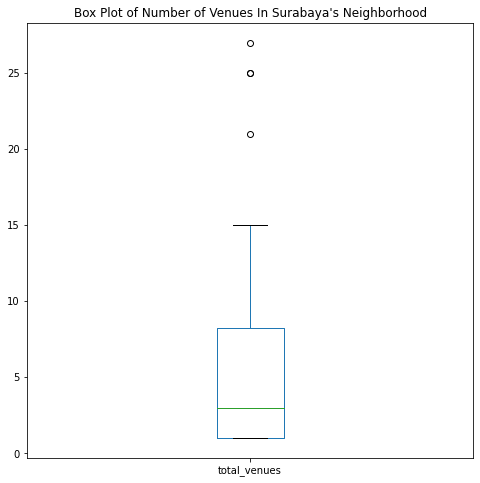

In [17]:
df_venues_grouped.plot(kind='box', figsize=(8, 8))
plt.title("Box Plot of Number of Venues In Surabaya's Neighborhood")
plt.show()

We can observe a few key observations from the box plot:

1. The minimum number of total venues is 1 and the maximum number (Q3 + 1.5*IQR) is 15, 
2. 25% of neighborhoods have 1 or fewer venues (First quartile).
3. 50% of neighborhoods have 3 venues (Median number).
4. 75% of neighborhoods have around 8 or fewer venues (Third quartile).
5. There are 3 outliers, and we can confirm the neighborhoods as TEGALSARI, GENTENG, and GUBENG by looking at the bar graph
6. The data are right skewed (positively skewed) since the median is closer to the first quartile than to the third quartile

We can see the full statistic summary of the total venues by using the .describe() method on the data frame.

In [18]:
df_venues_grouped.describe()

,total_venues
count,28.000000
mean,7.071429
std,8.123713
min,1.000000
25%,1.000000
50%,3.000000
75%,8.250000
max,27.000000


### Set Features For Clustering

In [19]:
X = pd.get_dummies(df_venues[['venue_category']], prefix="", prefix_sep="")
X.head(5)

,Airport Terminal,American Restaurant,Arcade,Asian Restaurant,Australian Restaurant,Bakery,Balinese Restaurant,Basketball Court,Bed & Breakfast,Bistro,...,Shoe Store,Shopping Mall,Soccer Field,Soup Place,Spa,Steakhouse,Sundanese Restaurant,Supermarket,Sushi Restaurant,Toll Booth
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X.insert(0, 'neighborhood_name', df_venues['neighborhood_name'], True)
X.head()

,neighborhood_name,Airport Terminal,American Restaurant,Arcade,Asian Restaurant,Australian Restaurant,Bakery,Balinese Restaurant,Basketball Court,Bed & Breakfast,...,Shoe Store,Shopping Mall,Soccer Field,Soup Place,Spa,Steakhouse,Sundanese Restaurant,Supermarket,Sushi Restaurant,Toll Booth
0,ASEMROWO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BENOWO,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,BUBUTAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BUBUTAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BUBUTAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
X_grouped = X.groupby('neighborhood_name').mean().reset_index()
X_grouped.head(10)

,neighborhood_name,Airport Terminal,American Restaurant,Arcade,Asian Restaurant,Australian Restaurant,Bakery,Balinese Restaurant,Basketball Court,Bed & Breakfast,...,Shoe Store,Shopping Mall,Soccer Field,Soup Place,Spa,Steakhouse,Sundanese Restaurant,Supermarket,Sushi Restaurant,Toll Booth
0,ASEMROWO,0.0,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,0.00,...,0.0,0.000,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0
1,BENOWO,0.0,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,0.00,...,1.0,0.000,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0
2,BUBUTAN,0.0,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,0.00,...,0.0,0.125,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0
3,BULAK,0.0,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,0.00,...,0.0,0.000,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0
4,GAYUNGAN,0.0,0.00,0.0,0.000000,0.0,0.125,0.00,0.0,0.00,...,0.0,0.000,0.0,0.00,0.00,0.125,0.0,0.0,0.0,0.0
5,GENTENG,0.0,0.04,0.0,0.000000,0.0,0.040,0.00,0.0,0.04,...,0.0,0.040,0.0,0.08,0.00,0.040,0.0,0.0,0.0,0.0
6,GUBENG,0.0,0.00,0.0,0.040000,0.0,0.080,0.04,0.0,0.00,...,0.0,0.000,0.0,0.00,0.04,0.000,0.0,0.0,0.0,0.0
7,GUNUNG ANYAR,0.0,0.00,0.0,0.333333,0.0,0.000,0.00,0.0,0.00,...,0.0,0.000,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0
8,JAMBANGAN,0.2,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,0.00,...,0.0,0.000,0.0,0.00,0.00,0.000,0.2,0.0,0.0,0.0
9,KARANG PILANG,0.0,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,0.00,...,0.0,0.000,0.0,0.00,0.00,0.000,0.0,0.0,0.0,1.0


In [22]:
X.shape

(198, 77)

### Return Top 8 Common Venues For Each Neighborhood

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    # count how many blank values
    blank_values = 0
    for ix in range(num_top_venues):
        if row_categories_sorted[ix] == 0: blank_values += 1
    
    npArrBlankValues = np.array(['' for val in range(blank_values)])
    npArrFinal = np.concatenate(
        (row_categories_sorted.index.values[0:num_top_venues-blank_values], npArrBlankValues), axis=None
    )

    return npArrFinal

In [24]:
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood_name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood_name'] = X_grouped['neighborhood_name']

for ind in np.arange(X_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(X_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(15)

,neighborhood_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,ASEMROWO,Food Truck,,,,,,,
1,BENOWO,Shoe Store,,,,,,,
2,BUBUTAN,Convenience Store,Bookstore,Donut Shop,Market,Fast Food Restaurant,Food Truck,Shopping Mall,Food Court
3,BULAK,Gift Shop,,,,,,,
4,GAYUNGAN,Boutique,Convenience Store,Steakhouse,Café,Bakery,Food Truck,Indonesian Restaurant,Seafood Restaurant
5,GENTENG,Coffee Shop,Indonesian Restaurant,Fried Chicken Joint,Soup Place,Furniture / Home Store,Bed & Breakfast,Japanese Restaurant,Multiplex
6,GUBENG,Indonesian Restaurant,Food Truck,Bakery,Chinese Restaurant,Multiplex,Kids Store,Convenience Store,Dumpling Restaurant
7,GUNUNG ANYAR,Convenience Store,Asian Restaurant,Cupcake Shop,,,,,
8,JAMBANGAN,Coffee Shop,Airport Terminal,Sundanese Restaurant,Indonesian Restaurant,,,,
9,KARANG PILANG,Toll Booth,,,,,,,


### Create Map Of Surabaya With Venues Marker

In [25]:
# Latitude & Longitude Of Surabaya City
centerPoint = (-7.2575, 112.7521)

In [39]:
# create map
map_clusters = folium.Map(location=[centerPoint[0], centerPoint[1]], zoom_start=12)

# add neighborhood markers to map
for lat, lng, neighborhood, total_venues in zip(
    df_neigh['lat'], 
    df_neigh['lng'],
    df_neigh['neighborhood_name'],
    df_venues_grouped['total_venues']
    
):
    label = folium.Popup(str(neighborhood) + ' (Total Venues: ' + str(total_venues) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=25,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.1,
        parse_html=False).add_to(map_clusters)  

# add venue markers to map
for lat, lng, venue, venue_category, neighborhood in zip(
    df_venues['venue_lat'], 
    df_venues['venue_lng'], 
    df_venues['venue'], 
    df_venues['venue_category'],
    df_venues['neighborhood_name']
):
    label = folium.Popup(str(venue) + ', ' + neighborhood + ' (' + str(venue_category) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)  
    
map_clusters

This is an image showing the location of neighborhoods on a map of the city Surabaya

In [42]:
Image(url= "https://raw.githubusercontent.com/vari8/applied-data-science-capstone/main/neighborhoods_surabaya.png")

### Clustering

Pre-process the feature data frame by removing the neighborhood name column, because the clustering model cannot process categorical variables.

In [27]:
X_final = X_grouped.drop('neighborhood_name', axis=1)
X_final.head()

,Airport Terminal,American Restaurant,Arcade,Asian Restaurant,Australian Restaurant,Bakery,Balinese Restaurant,Basketball Court,Bed & Breakfast,Bistro,...,Shoe Store,Shopping Mall,Soccer Field,Soup Place,Spa,Steakhouse,Sundanese Restaurant,Supermarket,Sushi Restaurant,Toll Booth
0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,1.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.125,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0


After the final data frame is ready to be consumed by the clustering model, then a model will be built using kMeans algorithm to cluster the neighborhoods into 5 different groups.

In [28]:
clusterNum = 5
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X_final)
labels = k_means.labels_
print(labels)

[3 0 0 1 0 0 0 0 0 2 0 0 4 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]


Now that the neighborhoods is already clustered and  label values are stored in a variable named labels, I will put the labels values back to the previous data frame.

In [29]:
X_grouped_label = X_grouped
X_grouped_label.insert(1, 'label', labels, True)
X_grouped_label.head(10)

,neighborhood_name,label,Airport Terminal,American Restaurant,Arcade,Asian Restaurant,Australian Restaurant,Bakery,Balinese Restaurant,Basketball Court,...,Shoe Store,Shopping Mall,Soccer Field,Soup Place,Spa,Steakhouse,Sundanese Restaurant,Supermarket,Sushi Restaurant,Toll Booth
0,ASEMROWO,3,0.0,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,...,0.0,0.000,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0
1,BENOWO,0,0.0,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,...,1.0,0.000,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0
2,BUBUTAN,0,0.0,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,...,0.0,0.125,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0
3,BULAK,1,0.0,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,...,0.0,0.000,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0
4,GAYUNGAN,0,0.0,0.00,0.0,0.000000,0.0,0.125,0.00,0.0,...,0.0,0.000,0.0,0.00,0.00,0.125,0.0,0.0,0.0,0.0
5,GENTENG,0,0.0,0.04,0.0,0.000000,0.0,0.040,0.00,0.0,...,0.0,0.040,0.0,0.08,0.00,0.040,0.0,0.0,0.0,0.0
6,GUBENG,0,0.0,0.00,0.0,0.040000,0.0,0.080,0.04,0.0,...,0.0,0.000,0.0,0.00,0.04,0.000,0.0,0.0,0.0,0.0
7,GUNUNG ANYAR,0,0.0,0.00,0.0,0.333333,0.0,0.000,0.00,0.0,...,0.0,0.000,0.0,0.00,0.00,0.000,0.0,0.0,0.0,0.0
8,JAMBANGAN,0,0.2,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,...,0.0,0.000,0.0,0.00,0.00,0.000,0.2,0.0,0.0,0.0
9,KARANG PILANG,2,0.0,0.00,0.0,0.000000,0.0,0.000,0.00,0.0,...,0.0,0.000,0.0,0.00,0.00,0.000,0.0,0.0,0.0,1.0


In [30]:
df_final = pd.DataFrame(columns=['neighborhood_name', 'label', 'lat', 'lng'])

# Join the 2 dataframes, and save the result to a new df variable
X_merged = X_grouped_label.join(df_neigh.set_index('neighborhood_name'), on='neighborhood_name')

df_final[['neighborhood_name', 'label', 'lat', 'lng']] = X_merged[['neighborhood_name', 'label', 'lat', 'lng']]

# Preview the df
df_final.head(5)

,neighborhood_name,label,lat,lng
0,ASEMROWO,3,-7.234688,112.685417
1,BENOWO,0,-7.226488,112.649662
2,BUBUTAN,0,-7.249962,112.730110
3,BULAK,1,-7.236774,112.789697
4,GAYUNGAN,0,-7.330843,112.724151


I am going to plot a Surabaya map showing the different positions of clustered neighborhoods.

In [47]:
# create map
map_clusters = folium.Map(location=[centerPoint[0], centerPoint[1]], zoom_start=12)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for neighborhood, cluster, lat, lng in zip(
    df_final['neighborhood_name'], 
    df_final['label'], 
    df_final['lat'], 
    df_final['lng']
):
    label = folium.Popup(str(neighborhood) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=25,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        opacity=0.1,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

This is an image showing the location of the clustered neighborhoods on a map of the city Surabaya

In [43]:
Image(url= "https://raw.githubusercontent.com/vari8/applied-data-science-capstone/main/clustered_neighborhoods_surabaya.png")

### Examine Clusters

I will examine each cluster to determine the unique characteristics that differentiate each cluster. I will look at neighborhood name, most common venues, and total venues for each neighborhood. To do so, I need a table that has all the necessary columns. There was no such a table on the previous analysis, so I will create a new one from some of the existing tables.

In [32]:
# Joinning tables
table_to_be_examined = neighborhoods_venues_sorted.join(df_venues_grouped.set_index('neighborhood_name'), on='neighborhood_name')
table_to_be_examined = table_to_be_examined.join(df_final.set_index('neighborhood_name'), on='neighborhood_name')

required_columns = ['neighborhood_name', 'label'] + list(neighborhoods_venues_sorted.columns[1:]) + ['total_venues']
table_to_be_examined = table_to_be_examined[required_columns]

table_to_be_examined.head()

,neighborhood_name,label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,total_venues
0,ASEMROWO,3,Food Truck,,,,,,,,1
1,BENOWO,0,Shoe Store,,,,,,,,1
2,BUBUTAN,0,Convenience Store,Bookstore,Donut Shop,Market,Fast Food Restaurant,Food Truck,Shopping Mall,Food Court,8
3,BULAK,1,Gift Shop,,,,,,,,1
4,GAYUNGAN,0,Boutique,Convenience Store,Steakhouse,Café,Bakery,Food Truck,Indonesian Restaurant,Seafood Restaurant,8


### Cluster 1

In [33]:
cluster1 = table_to_be_examined[table_to_be_examined['label'] == 0].sort_values(by='total_venues', ascending=False)
cluster1.head(10)

,neighborhood_name,label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,total_venues
23,TEGALSARI,0,Indonesian Restaurant,Bakery,Indonesian Meatball Place,Karaoke Bar,Coffee Shop,Health & Beauty Service,Bookstore,Gluten-free Restaurant,27
5,GENTENG,0,Coffee Shop,Indonesian Restaurant,Fried Chicken Joint,Soup Place,Furniture / Home Store,Bed & Breakfast,Japanese Restaurant,Multiplex,25
6,GUBENG,0,Indonesian Restaurant,Food Truck,Bakery,Chinese Restaurant,Multiplex,Kids Store,Convenience Store,Dumpling Restaurant,25
26,WONOCOLO,0,Bakery,Hotel,Pool Hall,Restaurant,Convenience Store,Coffee Shop,Café,Bubble Tea Shop,21
22,TAMBAKSARI,0,Convenience Store,Indonesian Restaurant,Asian Restaurant,Noodle House,Food Truck,Food,Bakery,Balinese Restaurant,15
20,SIMOKERTO,0,Seafood Restaurant,Food Truck,Cosmetics Shop,Arcade,Convenience Store,Soup Place,Bakery,Basketball Court,13
13,MULYOREJO,0,Indonesian Restaurant,Convenience Store,Bakery,Coffee Shop,Photography Lab,Fast Food Restaurant,Mobile Phone Shop,Supermarket,9
4,GAYUNGAN,0,Boutique,Convenience Store,Steakhouse,Café,Bakery,Food Truck,Indonesian Restaurant,Seafood Restaurant,8
2,BUBUTAN,0,Convenience Store,Bookstore,Donut Shop,Market,Fast Food Restaurant,Food Truck,Shopping Mall,Food Court,8
17,SAMBIKEREP,0,Bistro,Miscellaneous Shop,Housing Development,Market,Indonesian Restaurant,Flea Market,,,6


In [34]:
cluster1.shape

(23, 11)

Cluster 1 consists of 23 neighborhoods. The neighborhoods in this cluster have many venues compared to the neighborhoods from other clusters. As we can see, TEGALSARI neighborhood has the most number of venues in cluster 1, followed by GENTENG and GUBENG, and others. All the top 3 neighborhoods have food & beverages category as their first to fourth most common venues, and other entertainment categories as their fifth to eight most common venues.

Cluster 1 is considered to be the best cluster for establishing a new luxury 5-star hotel, as this cluster is the most congested in terms of venues. Then, I would recommend hotel owners or hotel managers to choose TEGALSARI, GENTENG, or GUBENG neighborhoods as the best neighborhoods for establishing a new luxury hotel.

TEGALSARI, GENTENG, and GUBENG have many venues for tourists to explore. Tourists have many options to try the local food from the nearby restaurants, and visit other places, such as karaoke bars and convenience stores. Various categories of venues, both culinary and entertainment venues will attract the attention of middle to high income tourists. 

### Cluster 2

In [35]:
cluster2 = table_to_be_examined[table_to_be_examined['label'] == 1].sort_values(by='total_venues', ascending=False)
cluster2.head(10)

,neighborhood_name,label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,total_venues
3,BULAK,1,Gift Shop,,,,,,,,1


Cluster 2 contains only one neighborhood and that neighborhood has only one venue. This cluster is not the best location for setting up a new luxury hotel, as the small number of venues is unlikely to attract high budget travelers.

### Cluster 3

In [36]:
cluster3 = table_to_be_examined[table_to_be_examined['label'] == 2].sort_values(by='total_venues', ascending=False)
cluster3.head(10)

,neighborhood_name,label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,total_venues
9,KARANG PILANG,2,Toll Booth,,,,,,,,1


Cluster 3 contains only one neighborhood. This cluster is not the best location for setting up a new luxury hotel, as the small number of venues is unlikely to attract high budget travelers.

### Cluster 4

In [37]:
cluster4 = table_to_be_examined[table_to_be_examined['label'] == 3].sort_values(by='total_venues', ascending=False)
cluster4.head(10)

,neighborhood_name,label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,total_venues
0,ASEMROWO,3,Food Truck,,,,,,,,1
16,RUNGKUT,3,Food Truck,,,,,,,,1


Cluster 4 contains two neighborhoods, each of which has only one venue, which is a food truck. This cluster is not the best location for setting up a new luxury hotel, as high-budget travelers may not be interested only in food trucks.

### Cluster 5

In [38]:
cluster5 = table_to_be_examined[table_to_be_examined['label'] == 4].sort_values(by='total_venues', ascending=False)
cluster5.head(10)

,neighborhood_name,label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,total_venues
12,LAKARSANTRI,4,Pool,,,,,,,,1


Cluster 5 contains only one neighborhood. This cluster is not the best location for setting up a new luxury hotel, as the small number of venues is unlikely to attract high budget travelers.

## Results and Discussion <a name="results"></a>

This project analyzes venues within a 500m radius of each neighborhood in the city of Surabaya. Venues data that is provided by Foursquare, and please note that no other location data form other parties is considered in this project. From the visualization of bar graph and boxplot, some neighborhoods have a high number of venues and are classified as outliers, while other neighborhoods have venue that is below the average. This shows the uneven distribution of venues among the neighborhoods in Surabaya.

The neighborhoods are clustered into 5 different groups. The clustering process performed by the kMeans model takes into account the similarity of venue categories, so that neighborhoods with the same venue are clustered to the same group. The neighborhoods that have been clustered are then plotted on the map to show the location of the cluster area above the city Surabaya city.

Cluster 1 consists of 23 neighborhoods. On the other hand, cluster 4 has two neighborhoods, and other clusters have only one neighborhood. Cluster 1 was chosen because it contains the neighborhoods with the most number of venues compared to any other clusters. After that, I narrowed my focus to cluster 1 to select a few neighborhoods as potential candidates to be selected as a new luxury hotel location. TEGALSARI, GENTENG, and GUBENG are recommended as they are the top 3 neighborhoods in terms of total number of venues. Moreover, the three neighborhoods both have many culinary spots for deep-pocketed tourists to explore.

The recommended neighborhoods should not be directly considered as a major factor in choosing which area in Surabaya is the best place to set up a new luxury hotel. Recommendations are made based on the similarity of venues between neighborhoods in Surabaya. There are still many other factors, such as competitors, hotel concepts, and prices that must be considered before choosing the best location to establish a 5-star hotel in Surabaya.

## Conclusion <a name="conclusion"></a>

This projects aims to assess hotel owners or hotel managers in deciding which neighborhood(s) in Surabaya to choose to establish a new 5-star hotel. By obtaining relevant data, pre-processing, and conducting Exploratory Data Analysis (EDA) on the data, we can see the characteristics of each neighborhood in terms of venues. In the final step, clustering is carried out to group similar neighborhoods that have the same venues categories, and the results are plotted on a map of Surabaya. Therefore, insights can be found to recommend specific  neighborhoods in which the cluster should be highly considered when deciding the final location for setting up a luxury hotel.

The venue-based similarity recommendation from this prject should be used only as a consideration. The final decision made by the hotel owners or hotel managers are on their own, and the outcome of the decision is beyond the responsibility of the author on this project.